In [26]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import normalize
import pandas as pd
%matplotlib inline

In [27]:
videosArray = glob.glob("Videos/*.mp4")
videosHeadSizeRatio = np.array([0.044,0.249,0.024]) #head size (circle) / image size 
videosHeadSizeRelativeRatio = np.array([2,10,1]) #consider lowest ratio as a baseline (scalar=1 for the last video in the array) - the rest are ratio relative to the baseline 
videosScore = np.zeros_like(videosArray)

print(videosArray)


['Videos\\high-score-cat.mp4', 'Videos\\lowscore-cat.mp4', 'Videos\\medium-scoree-cat.mp4']


In [28]:
def calculateMovements(cap,ratio_scalar,method):
    if cap.isOpened() == False:
        print("error, file not found")
        return 0
    videoLength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    mag_data = np.empty(videoLength)
    res, frame1 = cap.read()
    prvsImg = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    prevFlow = None
    i = 0
    movementThreshold = 10 #this is base number for movement based on some experiments. This is still an open question
    #2a - bigger object --> we need bigger threadhold to consider movement 
    if method == '2a':
        if ratio_scalar < 1: #by head size ratio
            movementThreshold += round(ratio_scalar*100) #we must have big threshold for big head. for 0.24 head size ratio, threshold will become 34 - 24 + base threshold of 10.
        else:
            movementThreshold += ratio_scalar*4 #by head relative size + some factor. we need to come up with a better way to distinguish between the values 
    while True:
        frameExists, frame2 = cap.read()
        if not frameExists:
            break
        nextImg = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvsImg,nextImg, None, 0.5, 3, 15, 3, 5, 1.2, 0) #default recommended params
        mag, _ = cv2.cartToPolar(flow[:,:,0], flow[:,:,1],angleInDegrees=True) #convert into polar form
        mag = np.nan_to_num(mag) #replace NaN's with 0's and inf with large numbers
        mag_dist_1d = pd.DataFrame(mag.flatten()) #turn into 1d dataframe
        number_of_mag_cells = mag_dist_1d.count().get(0)       
        #2b - normolize mag values
        if method == '2b':
            if ratio_scalar < 1: #by head size ratio
                mag_dist_1d *= ratio_scalar #reducing values 
            else:
                mag_dist_1d *= 1-(1.0/ratio_scalar) #for ratio_scalar 10 (low score cat with big head), we will get 0.9. for smallar cats, we will get smallar values. just like head size scalar 
        if number_of_mag_cells > 0:
            precentageOfMovment = mag_dist_1d[mag_dist_1d[0] > movementThreshold].count().get(0)/number_of_mag_cells
            #2c - normolize the precentage of movement 
            if method == '2c':
                if ratio_scalar < 1:
                    precentageOfMovment *= ratio_scalar
                else:
                    precentageOfMovment *= 1-(1.0/ratio_scalar)
        else: 
            precentageOfMovment = 0.0
        mag_data[i] = precentageOfMovment
        prevImg = nextImg
        i += 1
    #remove righthand outliters
    mag_data = np.nan_to_num(mag_data)
    mag_data = removeOutliers(mag_data)
    return  mag_data,movementThreshold

In [29]:
def normalizeArray(arr): 
    maxi = arr.max()
    if maxi == 0:
        return arr
    for i in range(len(arr)):
        arr[i] = float(float(arr[i])/float(maxi))
    return arr
        

In [30]:
def removeOutliers(mag_data):
    arr_mean = np.mean(mag_data)
    arr_std = np.std(mag_data)
#     print("mean is " + str(arr_mean))
#     print("std is " + str(arr_std))
    final_mag_data = mag_data #temp
    final_mag_data = [x for x in mag_data if (x < arr_mean + 3*arr_std)]
    return final_mag_data

In [31]:
def plotMov(dist,plot_strategy):
    positions = np.arange(len(dist))
    axes = plt.gca()
    if plot_strategy == 1: #show everything on the same scale 
        axes.set_ylim([0,0.5])
    plt.bar(x=positions, height=dist, width=1)
    plt.show()
# plt.hist(dist, bins=10)

In [32]:
#return precentage of movements along the video. movements defined as diff between frames bigger than alpha
def calculateScore(dist,alpha):
#     return float(np.count_nonzero((dist > alpha)/float(dist.size)))
    return np.sum(dist)


In [33]:
def run(videos_array,ratios_array,method,plot_strategy=0):
    for i in range(len(videos_array)):
        cap = cv2.VideoCapture(videos_array[i])
        mag_dist, used_threshold = calculateMovements(cap,float(ratios_array[i]),method)
        print("\n plotting for "+ videos_array[i] + " with ratio " + str(ratios_array[i]) + " with threshold " + str(used_threshold))
        plotMov(mag_dist,plot_strategy)
    print('***************************************************')
    #later, we will use score function to priorotize videos
#         score = calculateScore(maxiData,0.1)
#         videosScore[i] = score

# Using 2a method with head size ratio


 plotting for Videos\high-score-cat.mp4 with ratio 0.044 with threshold 14


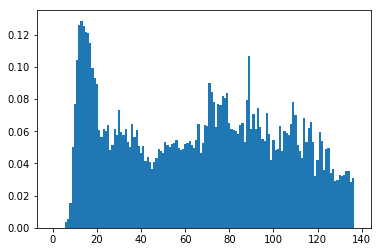


 plotting for Videos\lowscore-cat.mp4 with ratio 0.249 with threshold 35


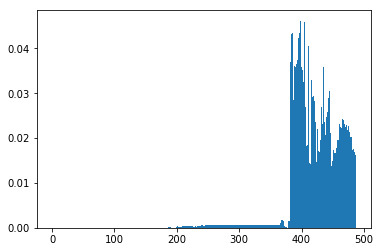


 plotting for Videos\medium-scoree-cat.mp4 with ratio 0.024 with threshold 12


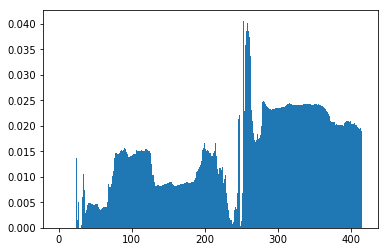

***************************************************


In [34]:
run(videosArray,videosHeadSizeRatio,'2a')

# Using 2b method with head size ratio

In [35]:
#run(videosArray,videosHeadSizeRatio,'2b') - this method is not working. the mag vlaues become really small (less than 2) and 
#                                           when we count the precentage of movement (for instance cells above 10, we get 0)

# Using 2c method with head size ratio


 plotting for Videos\high-score-cat.mp4 with ratio 0.044 with threshold 10


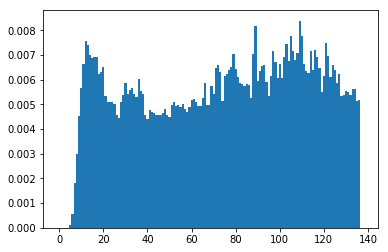


 plotting for Videos\lowscore-cat.mp4 with ratio 0.249 with threshold 10


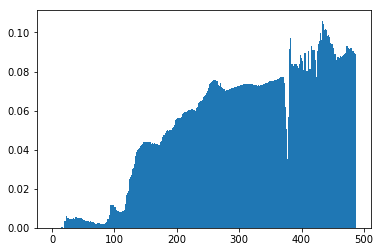


 plotting for Videos\medium-scoree-cat.mp4 with ratio 0.024 with threshold 10


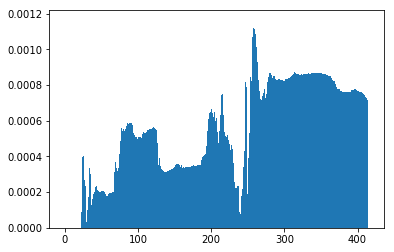

***************************************************


In [36]:
run(videosArray,videosHeadSizeRatio,'2c')

# Using 2a method with relative head size


 plotting for Videos\high-score-cat.mp4 with ratio 2 with threshold 18.0


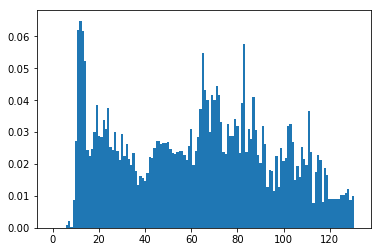


 plotting for Videos\lowscore-cat.mp4 with ratio 10 with threshold 50.0


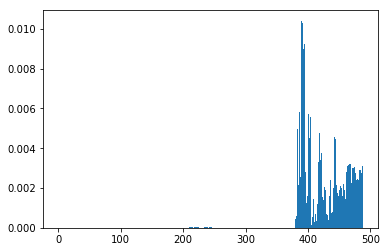


 plotting for Videos\medium-scoree-cat.mp4 with ratio 1 with threshold 14.0


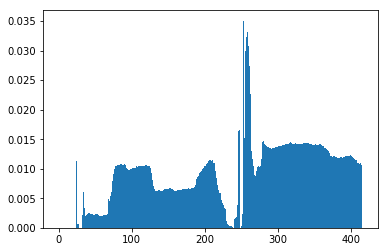

***************************************************


In [37]:
run(videosArray,videosHeadSizeRelativeRatio,'2a')

# Using 2b method with relative head size

In [38]:
# run(videosArray,videosHeadSizeRelativeRatio,'2b')

# Using 2c method with relative head size


 plotting for Videos\high-score-cat.mp4 with ratio 2 with threshold 10


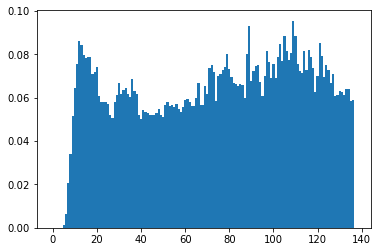


 plotting for Videos\lowscore-cat.mp4 with ratio 10 with threshold 10


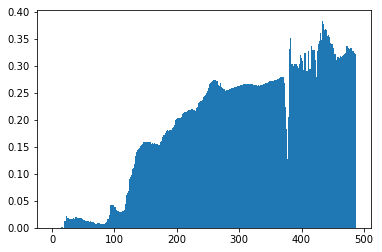


 plotting for Videos\medium-scoree-cat.mp4 with ratio 1 with threshold 10


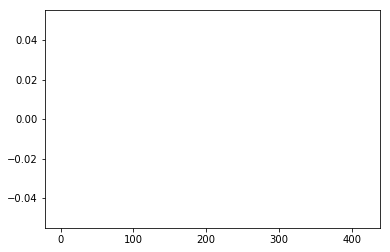

***************************************************


In [39]:
run(videosArray,videosHeadSizeRelativeRatio,'2c')

# Using 2a method with head size ratio with same scale


 plotting for Videos\high-score-cat.mp4 with ratio 0.044 with threshold 14


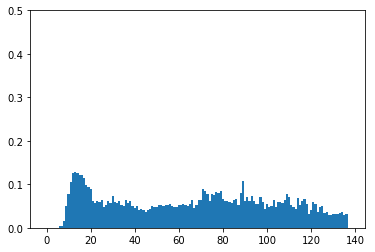


 plotting for Videos\lowscore-cat.mp4 with ratio 0.249 with threshold 35


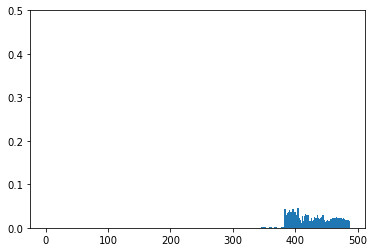


 plotting for Videos\medium-scoree-cat.mp4 with ratio 0.024 with threshold 12


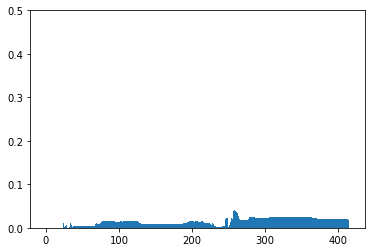

***************************************************


In [40]:
run(videosArray,videosHeadSizeRatio,'2a',1)

# Using 2c method with head size ratio with same scale


 plotting for Videos\high-score-cat.mp4 with ratio 0.044 with threshold 10


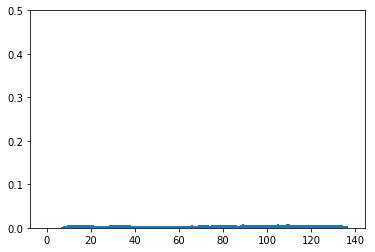


 plotting for Videos\lowscore-cat.mp4 with ratio 0.249 with threshold 10


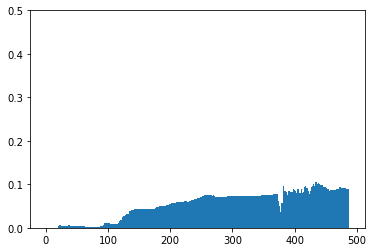


 plotting for Videos\medium-scoree-cat.mp4 with ratio 0.024 with threshold 10


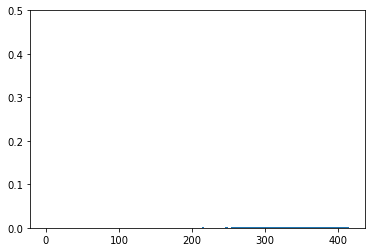

***************************************************


In [41]:
run(videosArray,videosHeadSizeRatio,'2c',1)

In [42]:
#Sort results
# videosAndScore = dict(zip(videosArray,videosScore))
# {k: v for k, v in sorted(videosAndScore.items(), key=lambda item: item[1],reverse=True)}